# Import the important packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import pearsonr
import dcor

import seaborn as sns
import matplotlib.pyplot as plt

from HelperClasses.LoadData import LoadCancer 
from HelperClasses.Correlation import Correlation  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
datasets = LoadCancer('/home/MarkF/DivideConquer/Results/GPL570',
    '/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/ICARUN/ica_independent_components_consensus.tsv')

Number of components split Lung cancer: 193
Number of components split Gastric cancer: 195
Number of components split Breast cancer: 339
Number of components split Sarcoma: 325
Number of components split Colorectal cancer: 190
Number of components split Prostate cancer: 106
Number of components split Renal cancer: 138
Number of components split HCC: 190
Number of components split Ovarian cancer: 158
Number of components split Lymphoma: 167
Number of components split Multiple myeloma: 89
Number of components split Normal: 605
Number of components split Leukemia: 102
Number of components split Adrenal cancer: 113
Number of components split Myelodysplastic syndrome: 84
Number of components split Brain cancer: 156
Number of components split Melanoma: 194
Number of components split HNSCC: 155
Number of components All data: 3776


In [3]:
# Load the cancer data
datasets = LoadCancer('/home/MarkF/DivideConquer/Results/GPL570',
    '/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/ICARUN/ica_independent_components_consensus.tsv')

Number of components split Lung cancer: 193
Number of components split Gastric cancer: 195
Number of components split Breast cancer: 339
Number of components split Sarcoma: 325
Number of components split Colorectal cancer: 190
Number of components split Prostate cancer: 106
Number of components split Renal cancer: 138
Number of components split HCC: 190
Number of components split Ovarian cancer: 158
Number of components split Lymphoma: 167
Number of components split Multiple myeloma: 89
Number of components split Normal: 605
Number of components split Leukemia: 102
Number of components split Adrenal cancer: 113
Number of components split Myelodysplastic syndrome: 84
Number of components split Brain cancer: 156
Number of components split Melanoma: 194
Number of components split HNSCC: 155
Number of components All data: 3776


First check finding a single component in a random chosen set that is not in big and get the biological meaning. For this experiment the Lymohoma set was chosen to investigate further

# Find a component in Lymphoma that is not in big

### Make the dataset

In [4]:
# Get the lymphoma columns
keep_cols = list(datasets.get_individual_small()['Lymphoma'].columns)
# Get the big columns
keep_cols.extend(datasets.get_sample_data().columns)
lymhoma_sample_df = datasets.get_all().loc[:,keep_cols]

### Calculate the corrleation

In [5]:
correlation = Correlation(datasets.get_individual_small()['Lymphoma'], 
                         datasets.get_sample_data())
correlation.get_half_correlation().max(axis=0).sort_values(ascending=True)

consensus independent component 105_Lymphoma    0.074116
consensus independent component 123_Lymphoma    0.119780
consensus independent component 108_Lymphoma    0.121326
consensus independent component 161_Lymphoma    0.121821
consensus independent component 85_Lymphoma     0.127483
                                                  ...   
consensus independent component 42_Lymphoma     0.614894
consensus independent component 131_Lymphoma    0.630441
consensus independent component 9_Lymphoma      0.630936
consensus independent component 30_Lymphoma     0.655972
consensus independent component 75_Lymphoma     0.657022
Length: 167, dtype: float64

In [6]:
# Check dcor for this component
dcor_calculated = []
for column in tqdm(datasets.get_sample_data().columns):
    dcor_calculated.append(dcor.distance_correlation(
        lymhoma_sample_df[column], lymhoma_sample_df['consensus independent component 123_Lymphoma']))
max(dcor_calculated)

100%|██████████| 3776/3776 [14:08<00:00,  4.45it/s]


0.10323724489640708

Consensus independent component 123_Lymphoma has really low correlation with the sample dataset implecating that it doesn't exist. Checked with dcor and Pearson. Both had a maximun score of about 0.1

# Furhter investigation lymphoma 123

### Does it corelate with a small set?

In [7]:
# Get the lymphoma columns
keep_cols = list(datasets.get_individual_small()['Lymphoma'].columns)
# Get the big columns
keep_cols.extend(datasets.get_sample_data().columns)
# Get a dataframe with all small sets except lymphoma
keep_cols = [x for x in datasets.get_all() if x not in keep_cols]
non_lymphoma_sample = datasets.get_all().loc[:,keep_cols]
correlation = Correlation(datasets.get_individual_small()['Lymphoma'], 
                          non_lymphoma_sample)
correlation.get_half_correlation().max(axis=0)['consensus independent component 123_Lymphoma']

0.11571773136327146

In [8]:
# Check dcor for this component
dcor_calculated = []
for column in tqdm(non_lymphoma_sample.columns):
    dcor_calculated.append(dcor.distance_correlation(
        non_lymphoma_sample[column], lymhoma_sample_df['consensus independent component 123_Lymphoma']))
max(dcor_calculated)

100%|██████████| 3332/3332 [12:20<00:00,  4.50it/s]


0.1096370683561887

Consensus independent component 123_Lymphoma has really low correlation with the other small datasets implecating that it doesn't exist. Checked with dcor and Pearson. Both had a maximun score of about 0.1

### GSEA 
Check if this component is significancly enriched (scores higher than 4) for three genesets

In [9]:
# Load all GSEA results
paths = [('GOBP', 'enrichment_matrix_Gene Ontology - Biolocal Processes.tsv'),
         ('HALLMARK', 'enrichment_matrix_Hallmark.tsv'),
         ('REACTOME','enrichment_matrix_Reactome.tsv')]
GSEA_ALL = {}
for path in paths:
    df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/Lymphoma/GSEA/{path[1]}',
                     sep='\t', index_col=0)
    df.index = [x.split(' -- ')[0].replace(f'{path[0]}_','') for x in df.index]
    GSEA_ALL[path[0]] = df['consensus independent component 123'].abs()


In [10]:
GSEA_ALL['GOBP'][GSEA_ALL['GOBP'] > 4].sort_values(ascending=False)

HIPPO_SIGNALING      4.259426
B_CELL_ACTIVATION    4.123082
Name: consensus independent component 123, dtype: float64

In [11]:
GSEA_ALL['HALLMARK'][GSEA_ALL['HALLMARK'] > 4].sort_values(ascending=False)

Series([], Name: consensus independent component 123, dtype: float64)

In [12]:
GSEA_ALL['REACTOME'][GSEA_ALL['REACTOME'] > 4].sort_values(ascending=False)

Series([], Name: consensus independent component 123, dtype: float64)

It is enriched in the GOBP dataset for both HIPPO_SIGNALING and B_CELL_ACTIVATION

### Guilt by association
Do a guilt by assiciation analysis to see if this results in any interesting enrichments

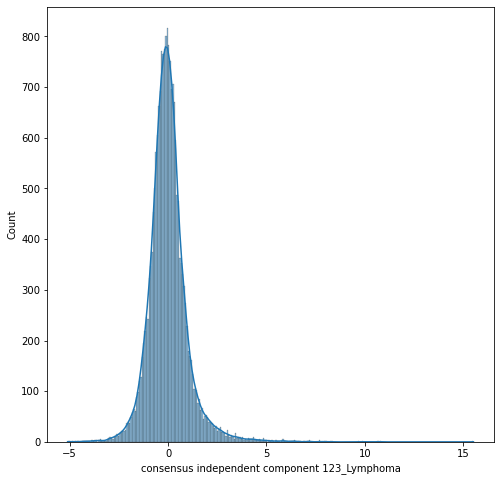

In [13]:
# Plot the gene weights 
plt.figure(figsize=(8,8))
sns.histplot(datasets.get_all()['consensus independent component 123_Lymphoma'], kde=True)
plt.show()

In [14]:
# Show the top 20 weighted genes in this component
names = pd.read_csv('/home/MarkF/DivideConquer/Tacna_confic/Genomic_Mapping_hgu133plus2_using_jetscore_30032018.txt',
           sep=None, engine='python')
names = names.groupby('SYMBOL').first().reset_index().set_index('ENTREZID')['SYMBOL']
plot_df = pd.DataFrame(
    datasets.get_all()['consensus independent component 123_Lymphoma'].sort_values(ascending=False))
plot_df = plot_df.join(names)
plot_df = plot_df.head(100)
plot_df.head(20)

,consensus independent component 123_Lymphoma,SYMBOL
6664,15.526040,SOX11
595,10.778926,CCND1
153478,10.655302,PLEKHG4B
2899,9.909925,GRIK3
1788,9.652309,DNMT3A
9315,8.326306,NREP
150568,8.244211,LINC01102
7473,8.052010,WNT3
23677,7.992590,SH3BP4
221756,7.712544,SERPINB9P1


In [15]:
# Print them to put in the Guilt by association website (83.162.250.102/GuiltByAssociation/)
print(' '.join(list(plot_df['SYMBOL'])))

SOX11 CCND1 PLEKHG4B GRIK3 DNMT3A NREP LINC01102 WNT3 SH3BP4 SERPINB9P1 NSG1 DCHS1 MEX3B ADAMTS6 FCGBP PLXNB1 LRRN1 CCDC191 ZNF135 PHYHD1 PPP1R17 HDGFRP3 CDK2AP1 LINC00865 TUNAR NSUN7 PLEKHA1 DBN1 KIAA2022 IGF1R GAB2 FBLN2 PON2 MARCKSL1 TBC1D9 IL23A ABCA6 ZBED3 PELI2 MDK SPIN1 PRICKLE1 C11orf95 FHL1 GTF2IRD1 KCNQ1 FAM69B MEGF6 CHL1 STMN1 MEX3D PYGM ROR1 ALOX5 DDAH2 APP ZNF853 CRIM1 SDK2 HOMER3 ATL1 ATP11A FADS3 RBM47 IQGAP2 CLMN ARHGAP6 MYO15B KHDRBS2 PWWP2B RNGTT LGALS3BP SPAG9 MSR1 LDOC1L TIMP2 TMEM237 BAIAP3 CREB3L4 LOC101927815 LOC100506098 ZSCAN2 PADI4 ABCA9 SETMAR LOC729970 CNN3 TMEM64 FNBP1L EPOR DZANK1 KDM5B TUBA1A LHFPL2 BEX4 LCK MS4A14 RNASE6 ZNF618 ZNF629


### CNA
Check if the component is a copy number alteration

In [16]:
cna_df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/Lymphoma/CNA_TC'
                     '/_extreme_valued_regions_all_chromosomes.txt', sep='\t')
cna_df = cna_df[cna_df['extreme_value_region_status'] != 0]
cna_df = cna_df[cna_df['mappings_in_region'] >= 10]
cna_df[cna_df['name'] == 'consensus independent component 123']

,chrom,chromStart,chromEnd,name,extreme_value_region_status,mappings_in_region,hyperparameter


No copy number beause no items apear in this dataframe

## Mantle cell lymohoma
After analysing the top genes it gave a strong indication that this component explains a pathway related to mantle cell lymphoma.

The top weighed genes in this ES were shown in the table The top weighted gene expression was found to be SOX11. For this this gene research found that "SOX11 expression is highly specific for mantle cell lymphoma and identifies the cyclin D1-negative subtype". Moreover, CCND1, GRIK3, DNMT3A, and WNT3 all have literature supporting the fact that they link to mantle cell lymphoma. 

###  Mixing matrix
Showing which patient probably have lymphoma

In [17]:
mixing_matrix = pd.read_csv(
    '/home/MarkF/DivideConquer/Results/GPL570/Lymphoma/ICARUN/ica_mixing_matrix_consensus.tsv',
    sep='\t', index_col=0)

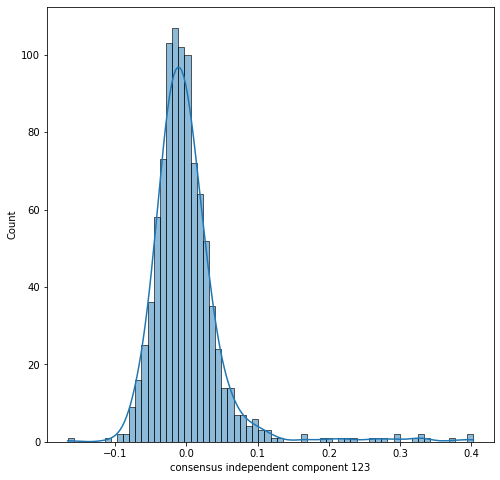

In [18]:
plt.figure(figsize=(8,8))
sns.histplot(mixing_matrix['consensus independent component 123'], kde=True)
plt.show()

In [19]:
(mixing_matrix['consensus independent component 123'] > 0.15).sum()

19

The patients with the extreme weights of higher than 0.15 probably have mantle cell lymphoma in this dataset. This are in total 19 samples

## Component in non consensus

Look into the individual 25 runs to investigate if it got found one time and got dropped in the consensus or if it didn't appear at all

In [20]:
save_cor = {}
# Load the column
important_cols = pd.DataFrame(datasets.get_all()['consensus independent component 123_Lymphoma'])

# Loop over the 25 runs
for i in tqdm(range(1,26)):
    df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/ICARUN2/'
                     f'ica_run_{i}_independent_components.tsv', sep='\t', index_col=0)
    correlation = Correlation(important_cols, df)    
    save_cor[i] = correlation.get_half_correlation().max()[0]
save_cor

100%|██████████| 25/25 [23:29<00:00, 56.36s/it]


{1: 0.12615491079081173,
 2: 0.09511131783762325,
 3: 0.16163755575820873,
 4: 0.07266880130133704,
 5: 0.11692379693195615,
 6: 0.1339181720430896,
 7: 0.10905063209173138,
 8: 0.10354108425649626,
 9: 0.1106837320718126,
 10: 0.10554538553270909,
 11: 0.11094138081157555,
 12: 0.33752357910084796,
 13: 0.11129523899835915,
 14: 0.13493698752571895,
 15: 0.11380800391784814,
 16: 0.11509933472398173,
 17: 0.09846158971498868,
 18: 0.1115695375201397,
 19: 0.11838486836912351,
 20: 0.11492356875484666,
 21: 0.10922907006589641,
 22: 0.09474542234145024,
 23: 0.09446016570578526,
 24: 0.1016347211696918,
 25: 0.11265623078315506}

The biggest correlation is with a indivudal run on the 12th ica run. Load this in and investigate it a bit further. First look at what component causes the correlation

In [21]:
df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/ICARUN2/'
                 f'ica_run_12_independent_components.tsv', sep='\t', index_col=0)
correlation = Correlation(important_cols, df)    

In [22]:
correlation.get_half_correlation().max(axis=1).sort_values(ascending=False)

component 3061    0.337524
component 3259    0.117063
component 1868    0.094932
component 3389    0.084636
component 252     0.075185
                    ...   
component 1775    0.000011
component 1752    0.000010
component 232     0.000009
component 207     0.000006
component 735     0.000006
Length: 4868, dtype: float64

In [23]:
dcor.distance_correlation(important_cols, df['component 3061'])

0.2621408815578629

The component is correlates with is 3061. But really small correlation. Pearson score of 0.33 and dcor of 0.26

### Look at if they explain the same pathway

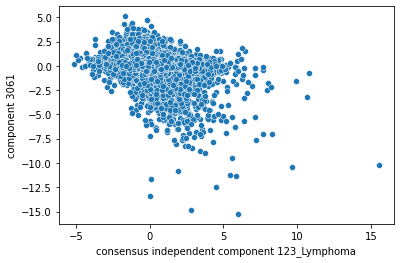

In [24]:
# Plot the two components against each other
df = df.join(important_cols)
sns.scatterplot(data=df, x='consensus independent component 123_Lymphoma', y='component 3061')
plt.show()

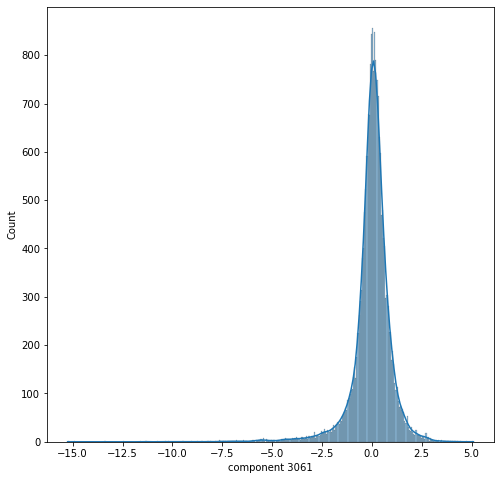

In [25]:
# See the top weights of this component
plt.figure(figsize=(8,8))
sns.histplot(df['component 3061'], kde=True)
plt.show()

In [26]:
# Get the highest genes that appear in both components
genes_df = df[['consensus independent component 123_Lymphoma', 'component 3061']]
genes_df = genes_df.join(names)
genes_small = genes_df[genes_df['component 3061'] < -5]['SYMBOL'].values
genes_lymp = genes_df[genes_df['consensus independent component 123_Lymphoma'] > 5]['SYMBOL'].values
list(set(genes_lymp) & set(genes_small))

['CDK2AP1',
 'MEX3B',
 'SOX11',
 'C11orf95',
 'NREP',
 'ZBED3',
 'PLXNB1',
 'DBN1',
 'MEX3D',
 'STMN1',
 'SPIN1',
 'DCHS1',
 'MARCKSL1',
 'DNMT3A',
 'MDK']

In [27]:
# Get the highest genes of the new component
genes_df = df[['consensus independent component 123_Lymphoma', 'component 3061']].abs()
genes_df = genes_df.join(names)
print(' '.join(list(genes_df.sort_values(by='component 3061',ascending=False)['SYMBOL'].head(100))))

DBN1 MEX3A CASC15 ZSCAN2 SOX4 MARCKSL1 C11orf95 TMSB15B DNMT3A SOX11 MDK TEAD2 ZNF627 SBK1 VASH2 ZBTB8A AP4M1 KDM5B MEX3B ZNF3 PLCG1 RPAIN FAM89B CCDC112 TMSB15A NINL NCK2 SMARCC1 DCHS1 NREP GPC2 STMN1 TTYH3 ZNF821 TMSB10 EFNA4 RBM15B YPEL1 KLHL24 IP6K2 TIA1 PAFAH1B3 CACNB3 KIAA0895L ZNF124 ZBED3 HN1 NARF TMTC4 MLLT11 ZNF195 TRIM24 PCAT6 PHF14 TGIF2 CSRNP2 ARL5B HNRNPA0 SEMA4C LMBR1L CDK2AP1 PANX1 MEX3D CBX1 FKBP7 KDM1A OCIAD2 ATP11C CCNJ ZNF146 HOMER3 ZBED4 HILPDA TUBA1A ZNF184 CBX2 ZSCAN16 SMARCE1 TTC3 NIPSNAP1 TMEM132A ZNF362 ADNP CYTH2 COMMD3 PCGF3 TP53BP2 KIAA1958 APEX1 SPIN1 ABL1 TMEM206 PLXNB1 UBE2Q2 DDAH2 FNBP1L YWHAQ TOR1AIP1 MSANTD3 GSTA4


This component with some correlation also has a link to mantle cell lymphoma. No clear evidence can be given which of the two is better. However, the component in the lymphoma run is found way easer as it appears in 50% of the runs. The big component is only found one time.

# Summary
Now look at all the new components found in the smaller run and see how many are enriched 

### In small but not in big

In [60]:
# Calculate correlation
correlation = Correlation(datasets.get_merged_small(), 
                         datasets.get_sample_data())
# Get all small components that are not in the big datasset with a pearson cutoff of 0.6
non_reproduced = correlation.get_half_correlation().max(axis=0)
non_reproduced = pd.DataFrame(non_reproduced[non_reproduced < 0.6]).reset_index()
# Get the component and the group in seperate columns
non_reproduced[['Component', 'Group']] = non_reproduced['index'].str.split('_', expand=True)
non_reproduced = non_reproduced.drop(['index', 0], axis=1)

In [61]:
#Get the enrichements and loop over every group to see for every component if it is enriched
paths = [('GOBP', 'enrichment_matrix_Gene Ontology - Biolocal Processes.tsv'),
         ('HALLMARK', 'enrichment_matrix_Hallmark.tsv'),
         ('REACTOME','enrichment_matrix_Reactome.tsv')]
count = {}
# Loop over all small sets
for cancer, df in non_reproduced.groupby('Group'):
    # Get the correct name for later
    cancer = cancer.replace(' ', '_')
    # Amount of component that don't correlate with big
    count[cancer] = {'New findings': len(df)}
    active_components = []
    cna_components = []
    # Loop over the GSEA
    for path in paths:
        # Load it in and remove the link
        gsea_df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/{cancer}/GSEA/{path[1]}',
                         sep='\t', index_col=0)
        gsea_df.index = [x.split(' -- ')[0].replace(f'{path[0]}_','') for x in gsea_df.index]
        # Only get the component that are in the current dataset
        gsea_df = gsea_df[df['Component']].abs()
        # Get the significant genesets (Score higher than 4) and put these esimated sources in a list
        gsea_df = gsea_df > 4
        gsea_df = gsea_df.sum()
        gsea_df = gsea_df[gsea_df > 0]
        active_components.extend(list(gsea_df.index))
        
    # Check if there are any CNA in the components
    cna_df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/{cancer}/CNA_TC'
                         '/_extreme_valued_regions_all_chromosomes.txt', sep='\t')
    cna_df = cna_df[cna_df['extreme_value_region_status'] != 0]
    cna_df = cna_df[cna_df['mappings_in_region'] >= 10]
    # Only leave the ones that are in the non-appearning group
    cna_df = cna_df[cna_df['name'].isin(df['Component'])]
    cna_components.extend(list(cna_df['name']))
    # Only leave the unique values and count them
    active_components = set(active_components)
    cna_components = set(cna_components)
    # The only enriched
    count[cancer][f'Enriched'] = len(active_components.difference(cna_components))
    # The only CNA
    count[cancer][f'CNA'] = len(cna_components.difference(active_components))
    # Both enriched and CNA
    count[cancer]['CNA and Enriched'] = len(active_components.intersection(cna_components))
count = pd.DataFrame(count).T
#count['Biological function'] = count['Enriched'] + count['CNA'] + count['CNA and Enriched']
count = count[['New findings', 'Enriched', 'CNA', 'CNA and Enriched']]

In [62]:
count

,New findings,Enriched,CNA,CNA and Enriched
Adrenal_cancer,113,40,21,35
Brain_cancer,147,53,29,60
Breast_cancer,129,13,76,32
Colorectal_cancer,133,32,37,59
Gastric_cancer,195,68,50,59
HCC,190,60,39,65
HNSCC,154,50,33,55
Leukemia,62,17,8,34
Lung_cancer,143,39,50,51
Lymphoma,161,63,34,56


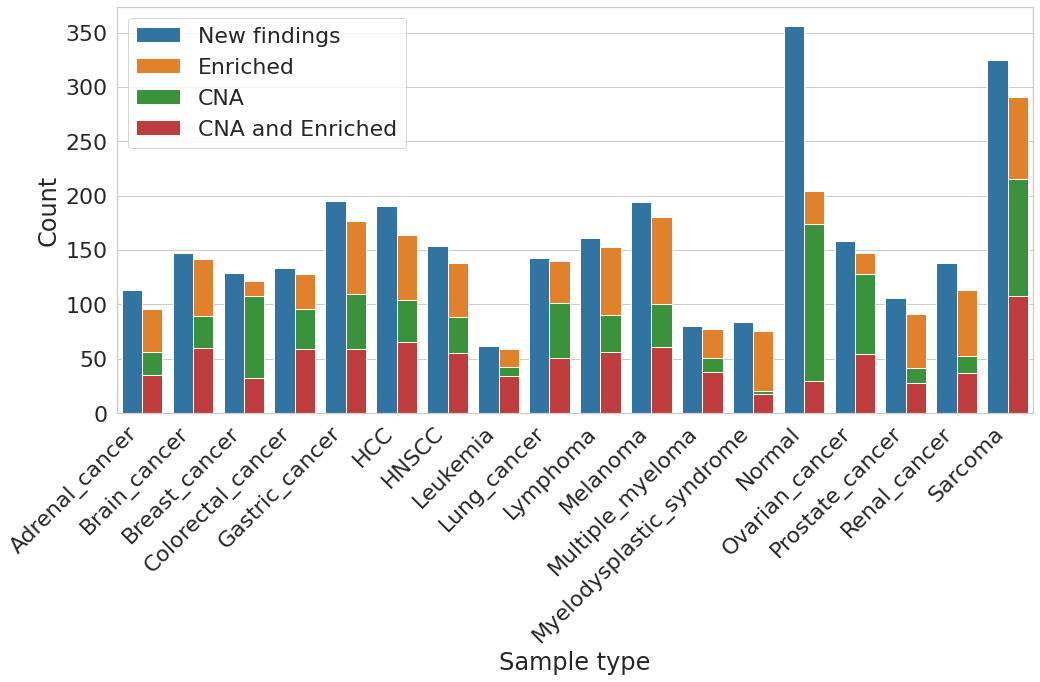

In [69]:
# Start plotting the table we just made
# First set colors and layout
colors = sns.color_palette("tab10")
sns.set(font_scale=2, style='whitegrid')

# Every bar needs to be plotted individually
plot_df = count.copy()
# Plot the total
plot_df['Enriched'] = plot_df['Enriched'] + plot_df['CNA'] + plot_df['CNA and Enriched']
plot_df = plot_df[['New findings', 'Enriched']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
plt.figure(figsize=(15,10))
g = sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[1]],
               orient='v')

# Leave out enriched so that one sicks out on top
plot_df = count.copy()
plot_df['CNA'] = plot_df['CNA'] + plot_df['CNA and Enriched']
plot_df = plot_df[['New findings', 'CNA']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[2]], ax=g,
               orient='v')

# Leave out CNA and eniched so CNA and enriched stays at the bottem
plot_df = count.copy()
plot_df = plot_df[['New findings', 'CNA and Enriched']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[3]], ax=g,
               orient='v')
# Make the legend
handles, labels = g.get_legend_handles_labels()
g.legend(handles=[handles[x] for x in [0,1,3,5]], labels=[labels[x] for x in [0,1,3,5]])
#plt.xticks(rotation=90)
# Rotate labels
# Rotate the labels
g.set_xticklabels(g.get_xticklabels(), 
                  rotation=45, 
                  horizontalalignment='right')
#plt.gca().get_xticklabels(O)[1].set_color('red') 
plt.xlabel('Sample type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/NewEnriched.png',dpi=300)

### In big but not in small

In [70]:
# Calculate correlation
correlation = Correlation(datasets.get_merged_small(), 
                         datasets.get_sample_data())
# Get all small components that are not in the big datasset with a pearson cutoff of 0.6
non_reproduced = correlation.get_half_correlation().max(axis=1)
non_reproduced = pd.DataFrame(non_reproduced[non_reproduced < 0.6]).reset_index()
# Get the component and the group in seperate columns
non_reproduced[['Component', 'Group']] = non_reproduced['index'].str.split('_', expand=True)
non_reproduced = non_reproduced.drop(['index', 0], axis=1)

In [71]:
#Get the enrichements and loop over every group to see for every component if it is enriched
count = {}
# Amount of component that don't correlate with big
count['New findings'] = len(non_reproduced)
active_components = []
cna_components = []
# Loop over the GSEA
for path in paths:
    # Load it in and remove the link
    gsea_df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/GSEA/{path[1]}',
                     sep='\t', index_col=0)
    gsea_df.index = [x.split(' -- ')[0].replace(f'{path[0]}_','') for x in gsea_df.index]
    # Only get the component that are in the current dataset
    gsea_df = gsea_df[df['Component']].abs()
    # Get the significant genesets (Score higher than 4) and put these esimated sources in a list
    gsea_df = gsea_df > 4
    gsea_df = gsea_df.sum()
    gsea_df = gsea_df[gsea_df > 0]
    active_components.extend(list(gsea_df.index))
# Check if there are any CNA in the components
cna_df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/CNA_TC'
                     '/_extreme_valued_regions_all_chromosomes.txt', sep='\t')
cna_df = cna_df[cna_df['extreme_value_region_status'] != 0]
cna_df = cna_df[cna_df['mappings_in_region'] >= 10]
# Only leave the ones that are in the non-appearning group
cna_df = cna_df[cna_df['name'].isin(df['Component'])]
cna_components.extend(list(cna_df['name']))
# Only leave the unique values and count them
active_components = set(active_components)
cna_components = set(cna_components)
# The only enriched
count[f'Enriched'] = len(active_components.difference(cna_components))
# The only CNA
count[f'CNA'] = len(cna_components.difference(active_components))
# Both enriched and CNA
count['CNA and Enriched'] = len(active_components.intersection(cna_components))
count = pd.DataFrame(count, index=['Sample dataset'])
count['Biological function'] = count['Enriched'] + count['CNA'] + count['CNA and Enriched']
count = count[['New findings', 'Enriched', 'CNA', 'CNA and Enriched']]

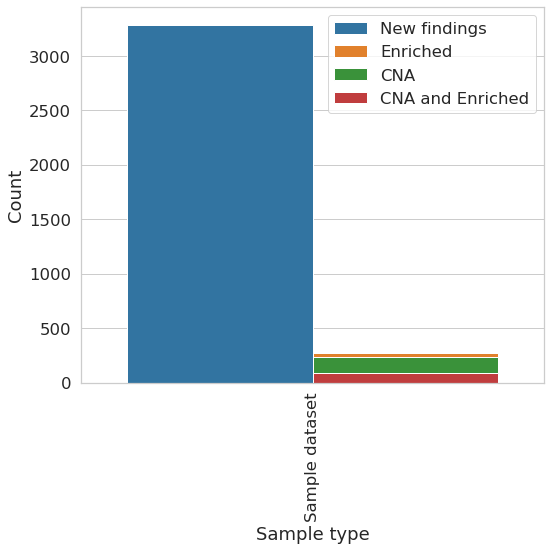

In [72]:
# Start plotting the table we just made
# First set colors and layout
colors = sns.color_palette("tab10")
sns.set(font_scale=1.5, style='whitegrid')

# Every bar needs to be plotted individually
plot_df = count.copy()
# Plot the total
plot_df['Enriched'] = plot_df['Enriched'] + plot_df['CNA'] + plot_df['CNA and Enriched']
plot_df = plot_df[['New findings', 'Enriched']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
plt.figure(figsize=(8,8))
g = sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[1]],
               orient='v')

# Leave out enriched so that one sicks out on top
plot_df = count.copy()
plot_df['CNA'] = plot_df['CNA'] + plot_df['CNA and Enriched']
plot_df = plot_df[['New findings', 'CNA']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[2]], ax=g,
               orient='v')

# Leave out CNA and eniched so CNA and enriched stays at the bottem
plot_df = count.copy()
plot_df = plot_df[['New findings', 'CNA and Enriched']]
plot_df = pd.melt(plot_df.reset_index(), id_vars='index', value_name='value')
sns.barplot(data=plot_df, x='index', y='value', hue='variable', palette=[colors[0], colors[3]], ax=g,
               orient='v')

# Make the legend
handles, labels = g.get_legend_handles_labels()
g.legend(handles=[handles[x] for x in [0,1,3,5]], labels=[labels[x] for x in [0,1,3,5]])
plt.xticks(rotation=90)
#plt.gca().get_xticklabels()[1].set_color('red') 
plt.xlabel('Sample type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/BadEnriched.png', dpi=300)

### Not alot of not found components show any real biology. The new method does not mis much